In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
# sklearn.metrics의 모든 필요한 함수들을 한 줄로 임포트
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_samples, silhouette_score

from scipy.stats import boxcox

import warnings
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler


# 1. 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

- SMOTE 효과: SMOTE 전략 변경 후, 훈련 단계에서의 모델 안정성(교차 검증 평균 정확도 98.85%, 표준편차 0.0094)이 획기적으로 개선되었습니다. 이전보다 훨씬 더 일관적이고 높은 성능을 보여줍니다.
- 소수 클래스 재현율: 가장 중요한 변화로, 데이터 수가 적었던 클래스 5의 재현율이 50%에서 100%로 크게 향상되었습니다. SMOTE가 소수 클래스를 놓치지 않고 잘 찾아내는 데 효과적이었음을 입증합니다.
- 정밀도와 오분류: 하지만, 클래스 5의 정밀도는 100%에서 50%로 하락했습니다. 이는 클래스 7의 샘플이 클래스 5로 오분류되는 경향 때문입니다. 전반적인 테스트 세트 정확도는 92%로 유지됩니다.

결론적으로, SMOTE는 모델의 훈련 안정성과 소수 클래스 재현율을 크게 개선했지만, 특정 클래스 간의 오분류(정밀도 문제)는 여전히 해결해야 할 과제입니다.

# 데이터 전처리

In [51]:
df = pd.read_csv('../data/Sleep_health_and_lifestyle_dataset.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data.csv'

In [45]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [46]:
# df_new.head()

In [47]:
df['BMI Category'].unique()

array(['Overweight', 'Normal', 'Obese', 'Normal Weight'], dtype=object)

## Normal Weight와 Normal 합치기

In [6]:
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

## Blood Pressure 나누기

In [7]:
if 'Blood Pressure' in df.columns:
        df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
        df.drop(columns=['Blood Pressure'], inplace=True)

### 여기다가 직업 분류 넣기

## 카테고리컬로 string 없애기

Fmale : 0
Male  : 1

None        : 0
Insomnia    : 1



In [8]:

# Sleep Disorder 제외하고 범주형 컬럼만 선택
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != 'Sleep Disorder']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # 나중에 디코딩용 저장


In [9]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1,1,27,9,6.1,6,42,6,2,77,4200,NaN,126,83
1,2,1,28,1,6.2,6,60,8,0,75,10000,NaN,125,80
2,3,1,28,1,6.2,6,60,8,0,75,10000,NaN,125,80
3,4,1,28,6,5.9,4,30,8,1,85,3000,Sleep Apnea,140,90
4,5,1,28,6,5.9,4,30,8,1,85,3000,Sleep Apnea,140,90


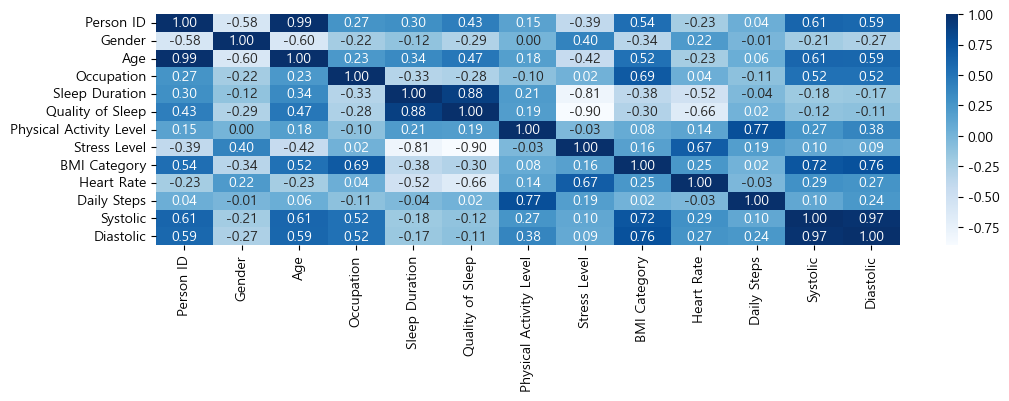

In [10]:
# 숫자형 컬럼만 선택
numeric_df = df.select_dtypes(include=['number'])

# 상관계수 계산
corr_matrix = numeric_df.corr()

# 시각화
plt.figure(figsize=(12, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.show()

In [11]:
df['Quality of Sleep'].value_counts()

Quality of Sleep
8    109
6    105
7     77
9     71
5      7
4      5
Name: count, dtype: int64

## 상관계수 낮은 데이터 지우기

In [12]:
cols_to_drop = ['Person ID', 'Daily Steps', 'Sleep Disorder', 'Sleep Duration']
existing_cols = [col for col in cols_to_drop if col in df.columns]
df.drop(existing_cols, axis=1, inplace=True)

In [13]:
print(df.columns)

Index(['Gender', 'Age', 'Occupation', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Systolic', 'Diastolic'],
      dtype='object')


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Gender                   374 non-null    int64
 1   Age                      374 non-null    int64
 2   Occupation               374 non-null    int64
 3   Quality of Sleep         374 non-null    int64
 4   Physical Activity Level  374 non-null    int64
 5   Stress Level             374 non-null    int64
 6   BMI Category             374 non-null    int64
 7   Heart Rate               374 non-null    int64
 8   Systolic                 374 non-null    int64
 9   Diastolic                374 non-null    int64
dtypes: int64(10)
memory usage: 29.3 KB


## 학습 데이터 / 타겟 데이터 나누기

In [15]:
# Quality of Sleep을 예측할 때

X = df.drop(['Quality of Sleep'], axis=1)
y = df['Quality of Sleep']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🔁 gubun 재설정 (핵심!)
df['gubun'] = 'train'
df.loc[X_test.index, 'gubun'] = 'test'

## 이상치 제거

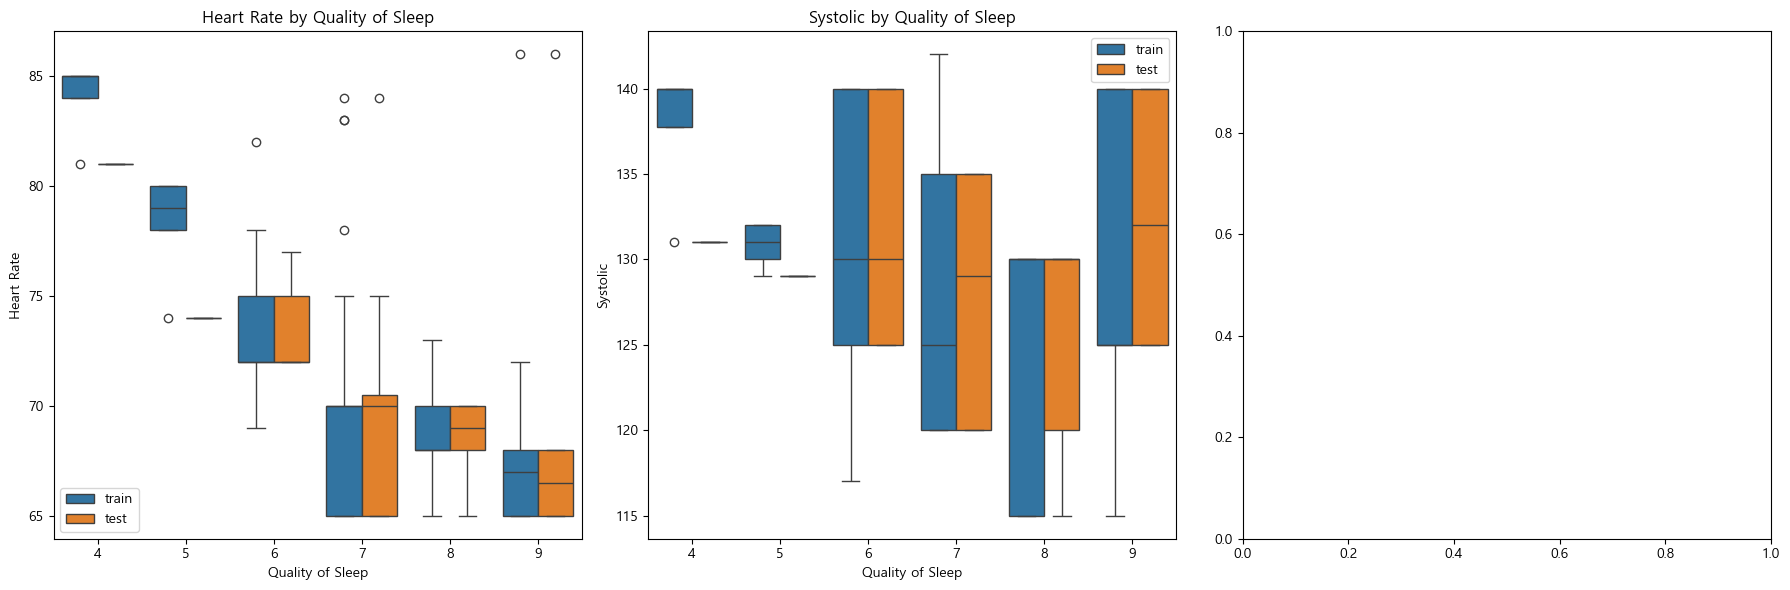

In [16]:
cols = ['Heart Rate', 'Systolic']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1행 3열

for i, col in enumerate(cols):
    sns.boxplot(x="Quality of Sleep", y=col, data=df, hue='gubun', ax=axes[i])
    axes[i].set_title(f"{col} by Quality of Sleep")
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [17]:
# 이상치 제거 조건 수동 정의
condition = (
    (df['Heart Rate'].between(60, 90)) &
    (df['Systolic'].between(110, 140))
)

df_clean = df[condition].copy()
print(f"\n이상치 제거 전 df 행 수: {len(df)}")
print(f"이상치 제거 후 df_clean 행 수: {len(df_clean)}")


이상치 제거 전 df 행 수: 374
이상치 제거 후 df_clean 행 수: 372


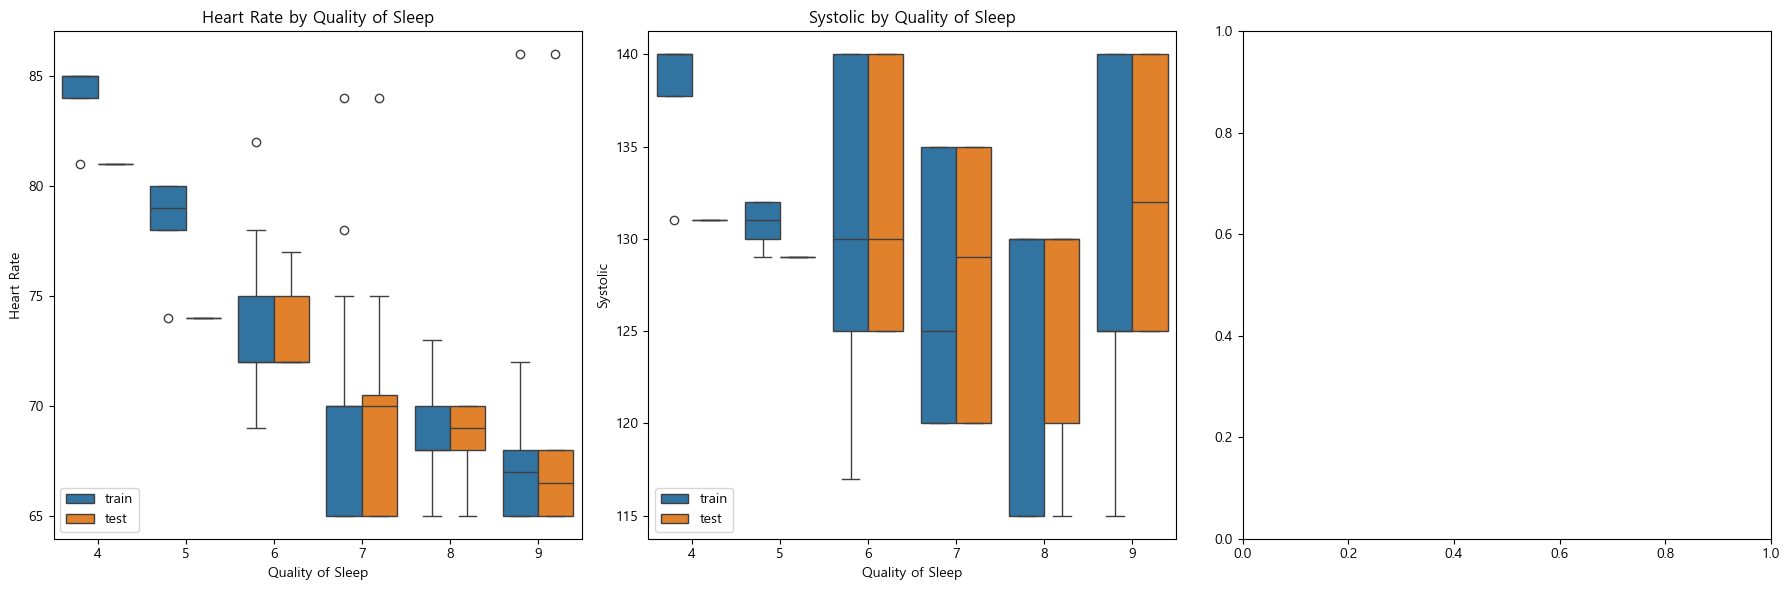

In [18]:
cols = ['Heart Rate', 'Systolic']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1행 3열

for i, col in enumerate(cols):
    sns.boxplot(x="Quality of Sleep", y=col, data=df_clean, hue='gubun', ax=axes[i])
    axes[i].set_title(f"{col} by Quality of Sleep")
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()


In [19]:
# 기존 코드 (Cell 17의 마지막 부분)
# ... (이상치 제거 후 df_clean 생성 코드) ...
# 예시: df_clean = df.copy() # 실제 df_clean 생성 로직은 더 복잡할 수 있습니다.
print("\n이상치 제거 완료. df_clean 생성됨.")


# --- 여기에 'gubun' 컬럼 제거 코드 삽입 ---

# 'gubun' 컬럼이 df_clean에 있다면 제거합니다.
# 이 컬럼은 모델 학습 피처로 사용되지 않으므로, X_model을 만들기 전에 제거합니다.
if 'gubun' in df_clean.columns:
    df_clean = df_clean.drop(columns=['gubun'], errors='ignore')
    print("\ndf_clean에서 'gubun' 컬럼 제거 완료.")
else:
    print("\ndf_clean에 'gubun' 컬럼이 없습니다. (이미 제거되었거나 존재하지 않음)")

# --- 'gubun' 컬럼 제거 코드 끝 ---


# 기존 코드 (Cell 20의 시작 부분)
# --- 5. 모델 학습 데이터 준비 ---
# [설명]: df_clean에서 'Quality of Sleep'을 타겟(y_model)으로, 나머지를 피처(X_model)로 분리합니다.
# 이 지점에서는 df_clean에 'gubun'이 없어야 합니다.
X_model = df_clean.drop(['Quality of Sleep'], axis=1, errors='ignore')
# ... (이후 LabelEncoder, Boxcox, train_test_split 등) ...


이상치 제거 완료. df_clean 생성됨.

df_clean에서 'gubun' 컬럼 제거 완료.


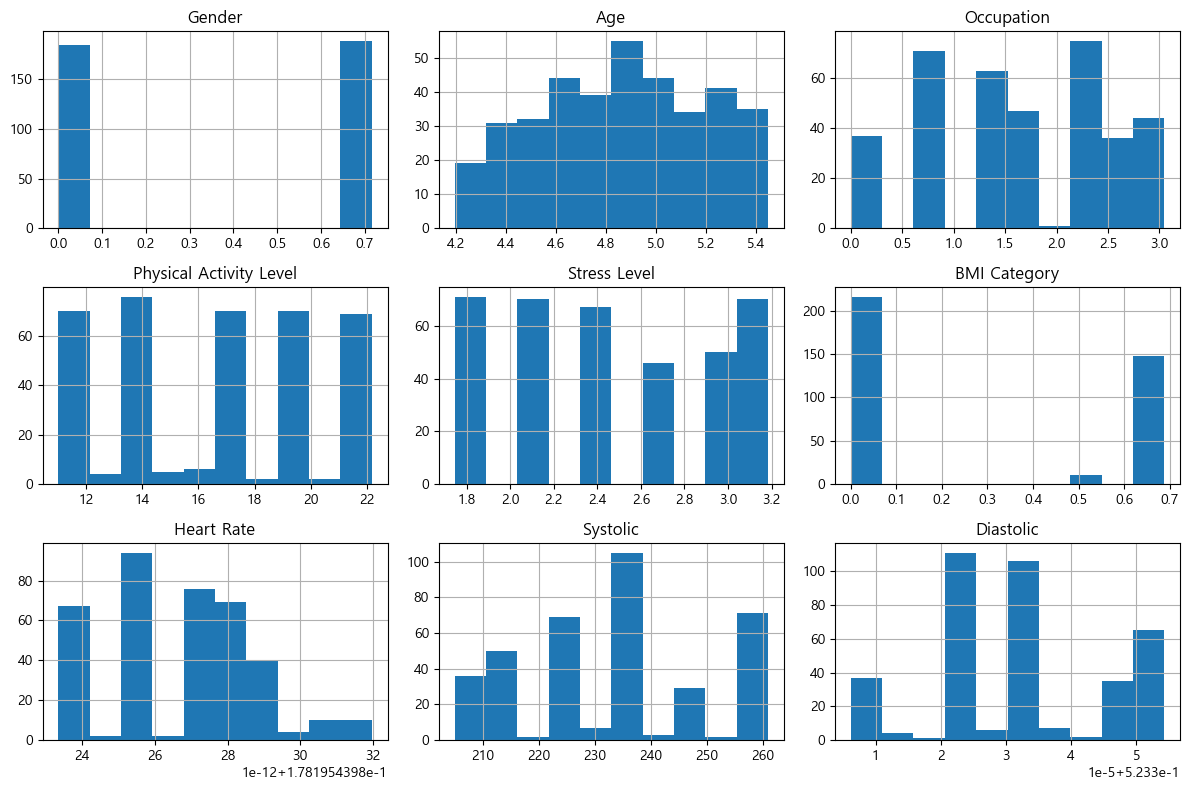

In [20]:
# 수치형 컬럼만 선택
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# boxcox 적용
for col in numeric_cols:
    X[col], _ = boxcox(X[col] + 1)  # +1: 0이나 음수 방지

# 히스토그램 확인
X.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [21]:
# --- 5. 모델 학습 데이터 준비 ---
# [설명]: df_clean에서 'Quality of Sleep'을 타겟(y_model)으로, 나머지를 피처(X_model)로 분리합니다.
X_model = df_clean.drop(['Quality of Sleep', 'gubun'], axis=1, errors='ignore') # 'gubun' 컬럼을 X_model에서 제거합니다.
y_model = df_clean['Quality of Sleep']

# Boxcox 변환 적용 (모델 학습 피처에만)
numeric_cols_model = X_model.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols_model:
    # [수정사항]: X[col] -> X_model[col]
    X_model[col], _ = boxcox(X_model[col] + 1) # +1: 0이나 음수 방지

# 모델 학습을 위한 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42, stratify=y_model
)
print("\n모델 학습 데이터 준비 완료.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


모델 학습 데이터 준비 완료.
X_train shape: (297, 9), y_train shape: (297,)


# 과적합 방지

## SMOTE 오버샘플링

In [22]:
# --- 여기에 SMOTE 오버샘플링 코드 삽입 (수정된 버전) ---
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"\nSMOTE 오버샘플링 전 훈련 세트 클래스 분포: {Counter(y_train)}")

# -----------------------------------------------------------------------------
# [수정사항]
# 1. sampling_strategy: 가장 많은 클래스 수의 1배(기존 수)로만 증강하도록 목표를 조정합니다.
#    (과도한 증강 방지 및 정밀도 하락 개선 시도)
# 2. k_neighbors: 최소 클래스 샘플 수에 맞춰 조정하여 오류 방지 및 안정성 확보.
# -----------------------------------------------------------------------------

# 1. y_train의 현재 클래스 분포 확인
current_class_counts = Counter(y_train)

# 2. 가장 많은 클래스의 샘플 수 확인
# 모든 소수 클래스를 이 수치만큼 증강시키는 것을 기본 목표로 합니다.
max_class_count_for_balancing = max(current_class_counts.values()) 

# 3. 각 클래스에 대한 목표 샘플 수를 딕셔너리로 정의
# 여기서는 모든 소수 클래스를 가장 많은 클래스의 수에 맞춰 증강합니다.
# (이전처럼 5~10배로 늘리는 것이 아닌, '균형 맞추기'에 집중)
sampling_strategy_dict_balanced = {
    cls: max_class_count_for_balancing
    for cls in current_class_counts.keys()
}
# 단, 현재 샘플 수가 목표보다 많은 클래스는 증강 대상이 아니므로, 그대로 둡니다.
# (SMOTE는 기본적으로 다수 클래스를 줄이지 않음)
for cls, count in current_class_counts.items():
    if count > max_class_count_for_balancing:
        sampling_strategy_dict_balanced[cls] = count


# 4. k_neighbors 값 조정 (ValueError 해결 및 안정성 확보)
# 최소 클래스 샘플 수 - 1 로 설정 (SMOTE가 자기 자신을 제외한 이웃을 찾으므로)
min_samples_in_any_class = min(current_class_counts.values())
smote_k_neighbors = min_samples_in_any_class - 1
if smote_k_neighbors < 1: # k_neighbors는 최소 1이어야 합니다.
    smote_k_neighbors = 1 

print(f"SMOTE k_neighbors 설정 값: {smote_k_neighbors}")
print(f"SMOTE sampling_strategy_dict (균형 맞추기 목표): {sampling_strategy_dict_balanced}")


# SMOTE 인스턴스 생성 및 적용
smote = SMOTE(random_state=42, 
              sampling_strategy=sampling_strategy_dict_balanced, 
              k_neighbors=smote_k_neighbors) 

# X_train과 y_train에 SMOTE를 적용하여 오버샘플링된 데이터를 생성합니다.
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"SMOTE 오버샘플링 후 훈련 세트 클래스 분포: {Counter(y_train_resampled)}")
print(f"오버샘플링 후 총 샘플 수: {len(X_train_resampled)}")
print("\n훈련 세트 오버샘플링 완료.")

# --- SMOTE 오버샘플링 코드 끝 ---


SMOTE 오버샘플링 전 훈련 세트 클래스 분포: Counter({8: 87, 6: 84, 7: 60, 9: 57, 5: 5, 4: 4})
SMOTE k_neighbors 설정 값: 3
SMOTE sampling_strategy_dict (균형 맞추기 목표): {6: 87, 8: 87, 7: 87, 9: 87, 4: 87, 5: 87}
SMOTE 오버샘플링 후 훈련 세트 클래스 분포: Counter({6: 87, 8: 87, 7: 87, 9: 87, 4: 87, 5: 87})
오버샘플링 후 총 샘플 수: 522

훈련 세트 오버샘플링 완료.


## KFold 겹 교차 검증 코드 위치

In [23]:
# 기존 코드 (SMOTE 오버샘플링 코드의 마지막 부분)
# print(f"SMOTE 오버샘플링 후 훈련 세트 클래스 분포: {Counter(y_train_resampled)}")
# print("\n훈련 세트 오버샘플링 완료.")

# --- K-Fold 교차 검증 구현 ---
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier를 다시 임포트합니다.

# StratifiedKFold를 사용하여 K-Fold 교차 검증 설정
# 'Quality of Sleep' 타겟 변수의 클래스 분포를 유지하면서 폴드를 나눕니다.
n_splits = 5 # 보통 5 또는 10으로 설정합니다.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 각 폴드에서의 성능 지표를 저장할 리스트
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

print(f"\n--- Stratified K-Fold 교차 검증 ({n_splits} 폴드) 시작 ---")

# SMOTE로 오버샘플링된 훈련 데이터 (X_train_resampled, y_train_resampled)를 사용합니다.
# 각 폴드 내에서 SMOTE를 적용할 경우 (파이프라인 사용 시) SMOTE는 파이프라인 안에 포함되지만,
# 현재는 전체 X_train에 SMOTE를 적용했으므로, 이 데이터를 폴드 분할에 직접 사용합니다.

for fold, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    # 훈련 폴드와 검증 폴드 데이터 분리
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    # [수정사항]: y_resampled.iloc[val_index] -> y_train_resampled.iloc[val_index]로 수정
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]


    # 모델 학습 (이전 RandomForestClassifier 모델 인스턴스를 재사용)
    rf_model_fold = RandomForestClassifier(random_state=42)
    rf_model_fold.fit(X_train_fold, y_train_fold)

    # 예측 수행
    y_pred_fold = rf_model_fold.predict(X_val_fold)

    # 성능 지표 계산 및 저장
    acc = accuracy_score(y_val_fold, y_pred_fold)
    prec = precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    rec = recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)

    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print(f"\n--- 교차 검증 최종 결과 ({n_splits} 폴드) ---")
print(f"평균 Accuracy: {np.mean(accuracy_scores):.4f} (표준편차: {np.std(accuracy_scores):.4f})")
print(f"평균 Precision: {np.mean(precision_scores):.4f} (표준편차: {np.std(precision_scores):.4f})")
print(f"평균 Recall: {np.mean(recall_scores):.4f} (표준편차: {np.std(recall_scores):.4f})")
print(f"평균 F1-Score: {np.mean(f1_scores):.4f} (표준편차: {np.std(f1_scores):.4f})")
# --- K-Fold 교차 검증 구현 끝 ---

# 기존 코드 (Cell 21의 시작 부분)
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train, y_train) # 이 부분은 K-Fold 후 최종 모델 학습 시에 사용됩니다.


--- Stratified K-Fold 교차 검증 (5 폴드) 시작 ---

--- 폴드 1/5 ---
  Accuracy: 0.9810
  Precision: 0.9820
  Recall: 0.9810
  F1-Score: 0.9809

--- 폴드 2/5 ---
  Accuracy: 0.9810
  Precision: 0.9815
  Recall: 0.9810
  F1-Score: 0.9809

--- 폴드 3/5 ---
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

--- 폴드 4/5 ---
  Accuracy: 0.9808
  Precision: 0.9813
  Recall: 0.9808
  F1-Score: 0.9808

--- 폴드 5/5 ---
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

--- 교차 검증 최종 결과 (5 폴드) ---
평균 Accuracy: 0.9885 (표준편차: 0.0094)
평균 Precision: 0.9889 (표준편차: 0.0090)
평균 Recall: 0.9885 (표준편차: 0.0094)
평균 F1-Score: 0.9885 (표준편차: 0.0094)


# 모델 학습

In [24]:
# 1. 모델 학습

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# 2. 예측
y_pred = rf_model.predict(X_test)

In [26]:
# 3. 평가

print("\n--- 모델 예측 및 평가 ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


--- 모델 예측 및 평가 ---
Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.88      1.00      0.93        21
           7       1.00      0.80      0.89        15
           8       0.95      0.91      0.93        22
           9       0.88      1.00      0.93        14

    accuracy                           0.92        75
   macro avg       0.95      0.87      0.89        75
weighted avg       0.93      0.92      0.92        75


Confusion Matrix:
[[ 1  0  0  0  0  0]
 [ 0  1  1  0  0  0]
 [ 0  0 21  0  0  0]
 [ 0  0  2 12  1  0]
 [ 0  0  0  0 20  2]
 [ 0  0  0  0  0 14]]


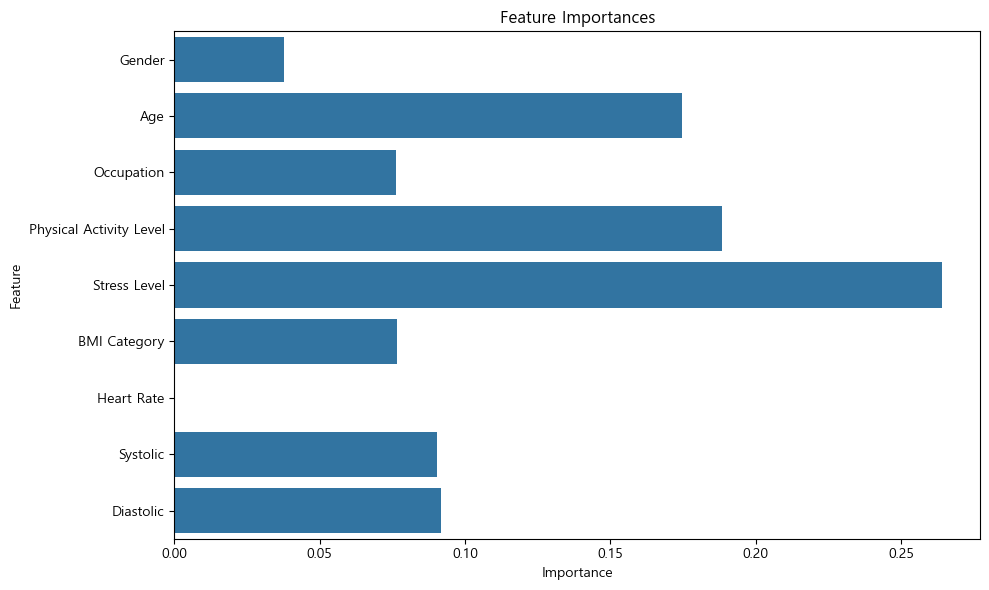

In [27]:
# 4. 피처 중요도 시각화
importances = rf_model_fold.feature_importances_
features = X_train.columns  # X가 아니라 X_train이 더 안전

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


--- 학습 곡선 ---


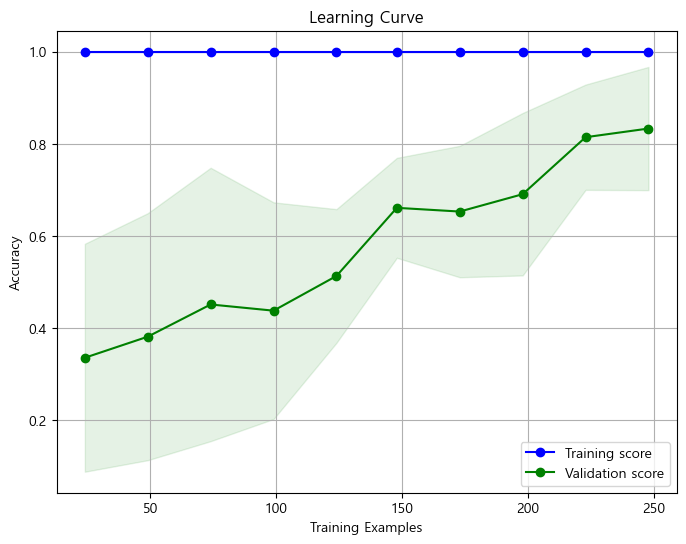


--- 교차 검증 점수 ---
Cross-validation scores: [0.91129032 0.94354839 0.64516129]
Mean CV accuracy: 0.8333, Std: 0.1337


In [28]:
# --- 8. 학습 곡선 및 교차 검증 점수 ---

# plot_learning_curve 함수 정의
# [설명]: 이 함수는 이전에 주석 처리되어 있던 것이 아니라, 별도로 정의되어 있어야 합니다.
# 이 코드를 코드의 상단 (임포트 아래, 다른 함수들과 함께)에 두는 것을 권장합니다.
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
    
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid()
    plt.show() # 차트를 주피터에 표시

# --- 학습 곡선 출력 ---
print("\n--- 학습 곡선 ---")
# [설명]: 이미 학습된 rf_model과 X_model, y_model을 사용하여 학습 곡선을 그립니다.
plot_learning_curve(rf_model_fold, X_model, y_model, cv=3)

# --- 교차 검증 점수 출력 ---
print("\n--- 교차 검증 점수 ---")
# [설명]: 이미 학습된 rf_model과 X_model, y_model을 사용하여 교차 검증 점수를 계산합니다.
scores = cross_val_score(rf_model_fold, X_model, y_model, cv=3, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f}, Std: {scores.std():.4f}")

# [삭제 필요]: 이 부분은 기존 코드에서 불필요한 중복입니다.
# # 데이터 분리 (X, y는 미리 준비된 상태여야 함)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# # 모델 생성 및 학습
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)

# 군집

## 필요 없는 데이터 제거

In [29]:
# [핵심]: 군집 분석에는 이상치를 제거하지 않은 '원본 df'를 사용합니다.
# 'Quality of Sleep' 컬럼 제거 (군집화 대상이 아니므로)
X_cluster = df.drop(columns=['Quality of Sleep', 'gubun'], errors='ignore') # 'gubun' 컬럼을 X_cluster에서 제거합니다.

## 순수 수치형 컬럼, 레이블 인코딩된 범주형 컬럼 명확히 구분

In [30]:
#    - 'Gender', 'Occupation', 'BMI Category'는 레이블 인코딩된 범주형입니다.
#    - 나머지는 순수 수치형입니다.
label_encoded_categorical_cols = ['Gender', 'Occupation', 'BMI Category'] # 레이블 인코딩된 범주형 컬럼 목록

## 순수 수치형 컬럼만 스케일링할

In [31]:
numerical_cols_for_clustering = [
    col for col in X_cluster.columns 
    if col not in label_encoded_categorical_cols and X_cluster[col].dtype in [np.int64, np.float64] # 숫자 타입 확인 추가
]

scaler = StandardScaler()
X_cluster_scaled = X_cluster.copy() # 원본 X_cluster 변경 방지 (스케일링 결과를 새 변수에 저장)
X_cluster_scaled[numerical_cols_for_clustering] = scaler.fit_transform(X_cluster_scaled[numerical_cols_for_clustering])
print("\n군집 분석을 위한 순수 수치형 데이터 스케일링 완료.")



군집 분석을 위한 순수 수치형 데이터 스케일링 완료.


## 클러스터링 수행

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # n_init='auto' 권장 설정
# 스케일링된 데이터로 군집화합니다. (X_cluster_scaled 사용)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# [수정사항]: 군집 결과를 X_cluster에 'Cluster' 컬럼으로 추가하고, 이 결과를 다시 원본 df에도 병합합니다.
X_cluster['Cluster'] = cluster_labels
df['Cluster'] = cluster_labels # 원본 df에 클러스터 결과 병합 (이후 recommend_sleep 등 분석에서 활용)
print("\n군집 분석 완료. 원본 df에 'Cluster' 컬럼 추가됨.")


군집 분석 완료. 원본 df에 'Cluster' 컬럼 추가됨.


## 실루엣 스코어 확인

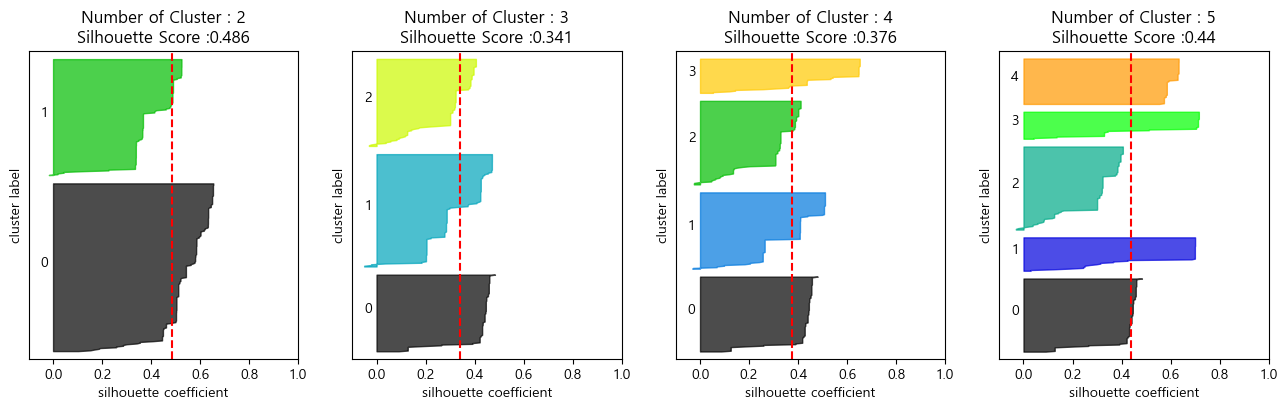

In [33]:

def my_chart(cluster_lists, X): 
    
    fig, axs = plt.subplots(figsize=(4*len(cluster_lists), 4), 
                            nrows=1, 
                            ncols=len(cluster_lists))

    for ind, k in enumerate(cluster_lists):
        
        kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1111) 
        cluster_labels = kmeans.fit_predict(X)
        
        sil_coef_mean = silhouette_score(X, cluster_labels)
        sil_coef      = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(k)+'\n' \
                          'Silhouette Score :' + str(round(sil_coef_mean,3)) )

        axs[ind].set_xlabel("silhouette coefficient")
        axs[ind].set_ylabel("cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X) + (k + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 막대 그래프
        for i in range(k):
            ith_cluster_sil_coef = sil_coef[cluster_labels==i]
            ith_cluster_sil_coef.sort()

            size_cluster_i = ith_cluster_sil_coef.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_coef, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_coef_mean, color="red", linestyle="--")

# 호출할 때
my_chart([2,3,4,5], X_cluster_scaled )


## 엘보차트 그리기

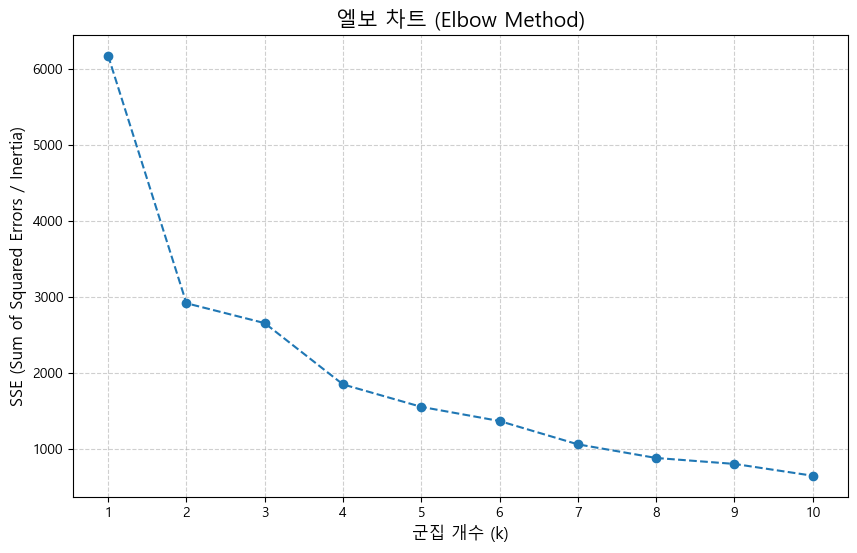


엘보 차트가 생성되었습니다. SSE 값이 급격히 줄어들다가 완만해지는 '팔꿈치' 지점을 찾아보세요.


In [34]:
# [설명]: K-Means에서 최적의 군집 개수(k)를 찾기 위한 엘보 차트를 그립니다.

# 군집 개수(k) 범위 설정
max_k = 10 # 테스트할 최대 군집 개수
sse = [] # 각 k에 대한 SSE(Sum of Squared Errors) 값을 저장할 리스트

# 각 k 값에 대해 K-Means 수행 및 SSE 계산
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_scaled) # 스케일링된 데이터 사용
    sse.append(kmeans.inertia_) # inertia_ 속성이 SSE 값입니다.

# 엘보 차트 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), sse, marker='o', linestyle='--')
plt.title('엘보 차트 (Elbow Method)', fontsize=15)
plt.xlabel('군집 개수 (k)', fontsize=12)
plt.ylabel('SSE (Sum of Squared Errors / Inertia)', fontsize=12)
plt.xticks(range(1, max_k + 1)) # x축 눈금 설정
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n엘보 차트가 생성되었습니다. SSE 값이 급격히 줄어들다가 완만해지는 '팔꿈치' 지점을 찾아보세요.")

## 군집 결과 시각화 (박스플롯)

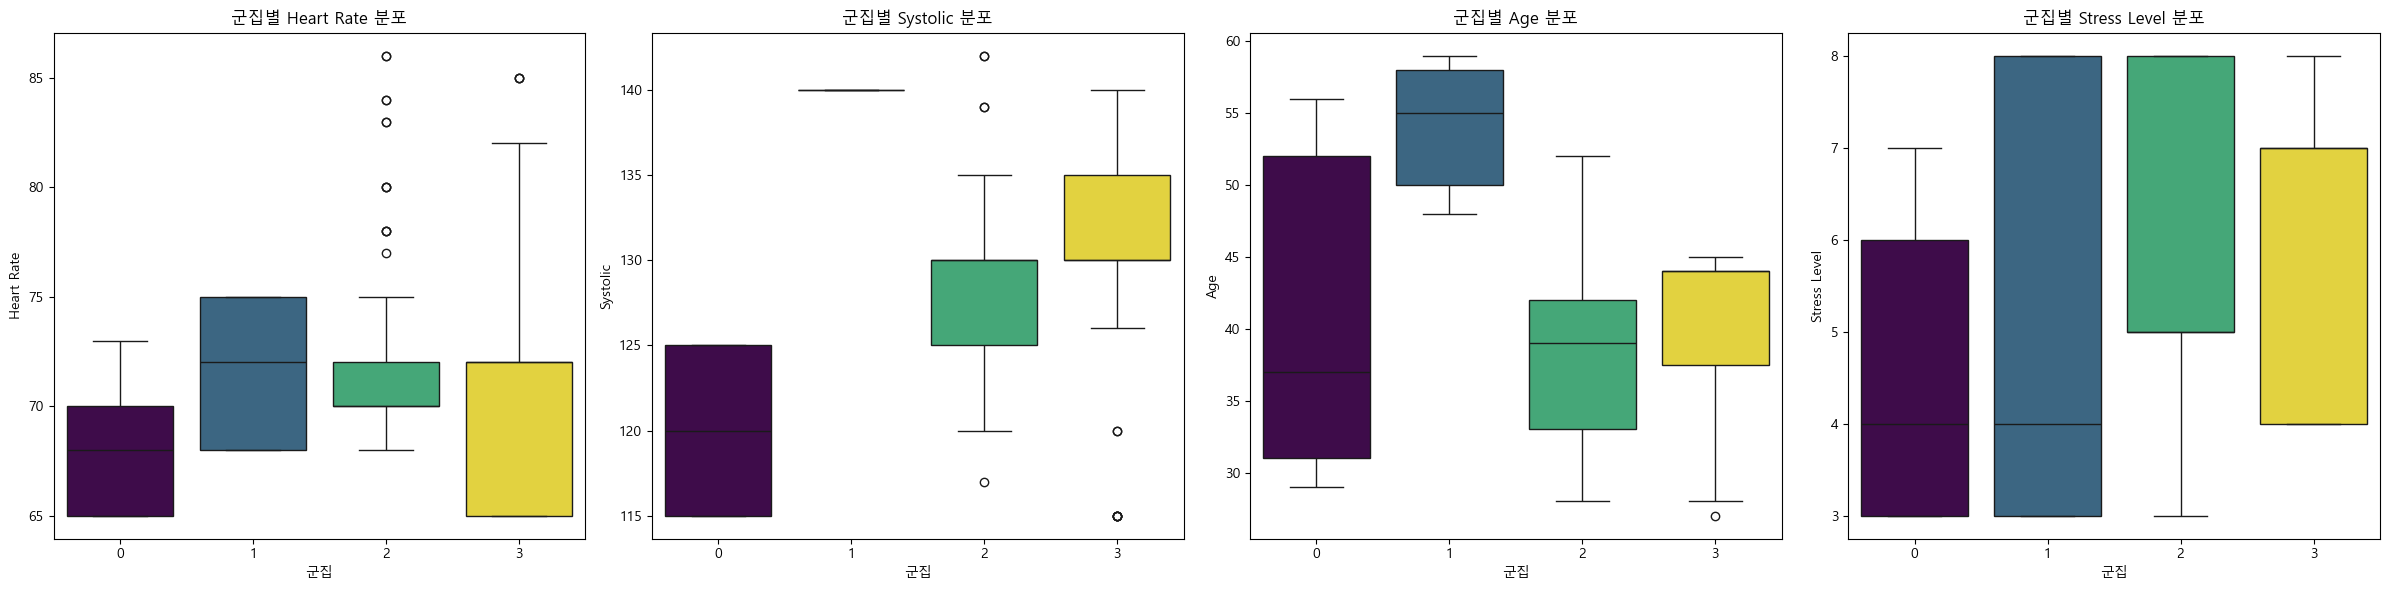

In [35]:

# [설명]: 원본 df에 추가된 'Cluster' 컬럼을 기준으로 박스플롯을 그립니다.
cols_to_plot_after_cluster = ['Heart Rate', 'Systolic', 'Age', 'Stress Level'] # 시각화할 피처 목록
fig, axes = plt.subplots(nrows=1, ncols=len(cols_to_plot_after_cluster), figsize=(len(cols_to_plot_after_cluster)*6, 6))

if len(cols_to_plot_after_cluster) == 1:
    axes = [axes] # 컬럼이 하나일 경우 axes가 단일 객체이므로 리스트로 감싸서 반복문 사용 가능하게 함

for i, col in enumerate(cols_to_plot_after_cluster):
    sns.boxplot(x="Cluster", y=col, data=df, ax=axes[i], palette='viridis', hue='Cluster', legend=False)
    axes[i].set_title(f"군집별 {col} 분포", fontsize=12)
    axes[i].set_xlabel("군집", fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
plt.tight_layout()
plt.show() # 차트 표시

## 다양한 K 값에 따른 2D 군집 산점도 시각화

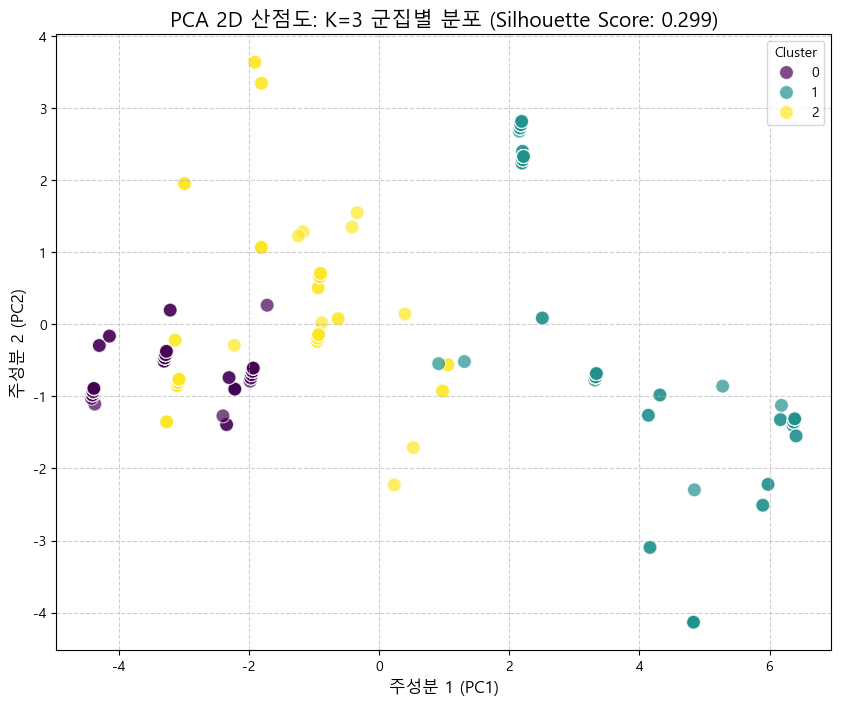

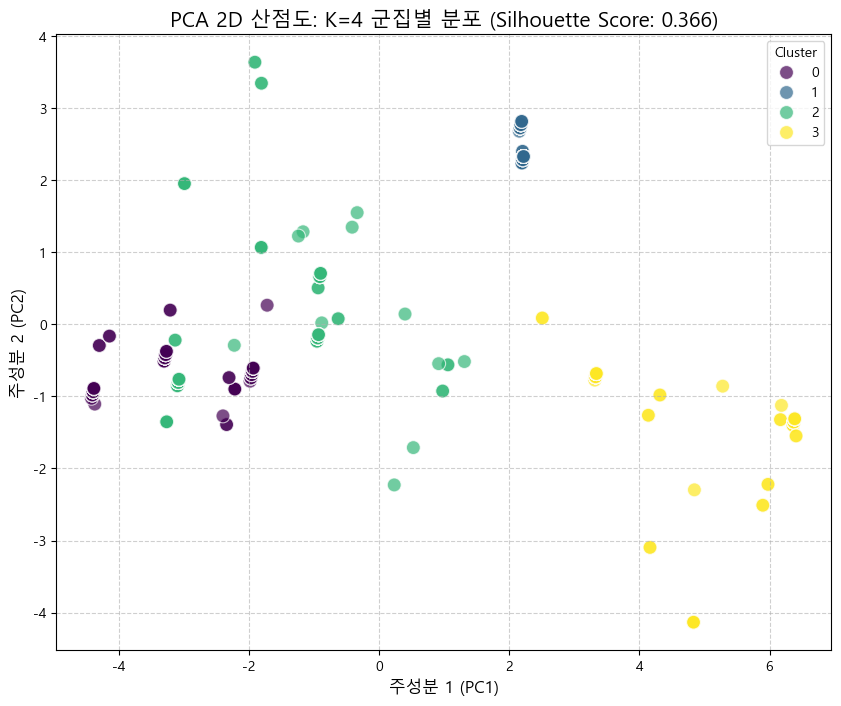

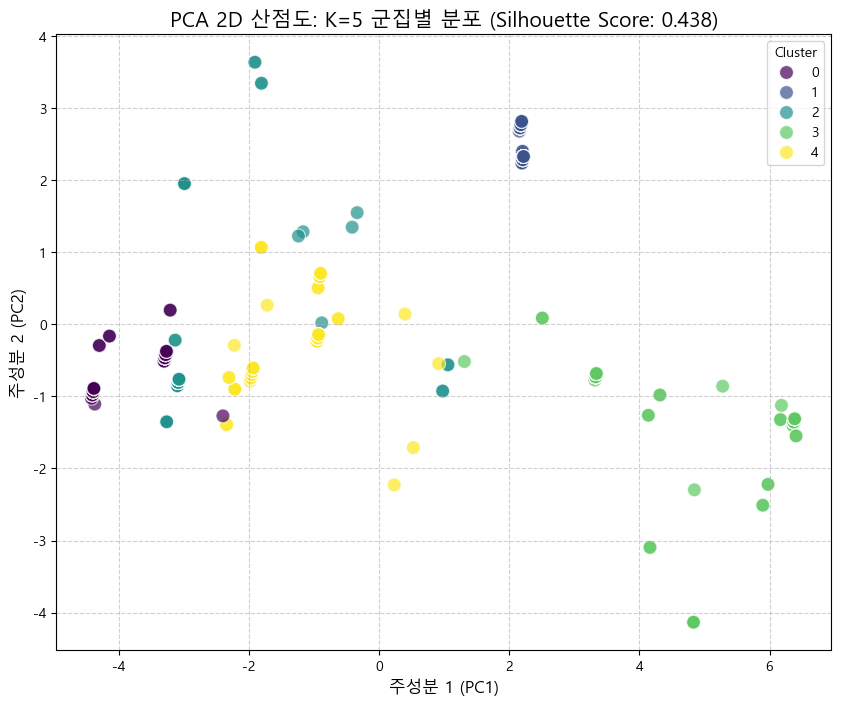


K=3, 4, 5일 때의 PCA 2D 산점도가 각각 생성되었습니다. 각 군집의 응집도와 분리도를 시각적으로 비교해보세요.


In [36]:
# [설명]: k=3, 4, 5일 때 각각 PCA를 이용한 2차원 산점도를 그려 군집 응집도를 시각적으로 비교합니다.
from sklearn.decomposition import PCA # PCA 임포트 (상단에 이미 임포트되어 있어야 함)

# 테스트할 k 값 리스트
k_values_to_plot = [3, 4, 5]

# 각 k 값에 대해 산점도 그리기
for k in k_values_to_plot:
    # 1. K-Means 군집화 수행 (스케일링된 데이터 X_cluster_scaled 사용)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_cluster_scaled)
    
    # 2. 실루엣 점수 계산 (응집도 지표)
    silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
    
    # 3. PCA를 이용해 2차원으로 차원 축소 (군집화에 사용했던 스케일링된 데이터 사용)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_cluster_scaled)
    
    # 4. PCA 결과와 군집 라벨을 포함하는 데이터프레임 생성
    # X_pca의 첫 번째 주성분을 'PC1', 두 번째 주성분을 'PC2'로 이름 붙입니다.
    # 'Cluster' 정보는 해당 k값의 cluster_labels를 사용합니다.
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels # 해당 k값의 클러스터 라벨을 pca_df에 추가
    
    # 5. 군집별 산점도 시각화
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, 
                    palette='viridis', s=100, alpha=0.7,
                    legend='full') # 'legend=full'로 범례를 명확하게 표시
    
    plt.title(f'PCA 2D 산점도: K={k} 군집별 분포 (Silhouette Score: {silhouette_avg:.3f})', fontsize=15)
    plt.xlabel('주성분 1 (PC1)', fontsize=12)
    plt.ylabel('주성분 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show() # 차트를 주피터에 표시

print("\nK=3, 4, 5일 때의 PCA 2D 산점도가 각각 생성되었습니다. 각 군집의 응집도와 분리도를 시각적으로 비교해보세요.")

## 군집 결과 분석 및 시각화

In [37]:
print("\n--- 군집별 평균 특성 (원본 df 기준) ---")
# [설명]: Cluster 컬럼이 추가된 원본 df를 사용하여 군집별 평균 특성을 확인합니다.
# 모든 컬럼에 대해 평균을 볼 수 있지만, 의미 있는 수치형 컬럼 위주로 보는 것이 좋습니다.
display(df.groupby('Cluster').mean(numeric_only=True)) # numeric_only=True 추가하여 경고 방지


# ✔ 방법 1. 범주형 컬럼들의 최빈값(mode) 보기
# [수정사항]: df를 사용하고, cluster_mode는 df의 컬럼 기준으로 생성
# 최빈값은 모든 컬럼 (수치형, 레이블 인코딩된 범주형)에 대해 볼 수 있습니다.
cluster_mode = df.groupby('Cluster').agg(lambda x: x.mode().iloc[0])
print("\n--- 군집별 특성 최빈값 (전체) ---")
pd.set_option('display.max_columns', None) # 모든 컬럼을 표시하도록 설정
display(cluster_mode)


--- 군집별 평균 특성 (원본 df 기준) ---


,Gender,Age,Occupation,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Systolic,Diastolic
Cluster,,,,,,,,,,
0,0.412844,40.045872,1.119266,8.018349,56.256881,4.321101,0.018349,67.605505,120.376147,78.550459
1,0.000000,53.953846,5.000000,7.523077,82.384615,5.492308,2.000000,71.569231,140.000000,95.000000
2,0.855932,38.372881,2.203390,7.177966,59.000000,6.042373,0.254237,71.542373,128.347458,83.652542
3,0.524390,41.182927,8.585366,6.402439,44.890244,5.768293,1.756098,70.475610,130.646341,85.987805



--- 군집별 특성 최빈값 (전체) ---


,Gender,Age,Occupation,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Systolic,Diastolic,gubun
Cluster,,,,,,,,,,,
0,0,53,2,8,75,3,0,65,125,80,train
1,0,50,5,9,75,8,2,75,140,95,train
2,1,43,3,8,90,5,0,70,130,85,train
3,1,44,10,6,45,7,2,72,130,85,train


## 범주형 변수의 비율 분석

In [38]:
print("\n--- 군집별 범주형 변수 비율 분포 ---")
# [수정사항]: 원본 df의 'Gender', 'Occupation', 'BMI Category' 컬럼만 명시적으로 사용
# 이 컬럼들은 LabelEncoder로 이미 숫자로 변환되어 있습니다.
display_categorical_cols = ['Gender', 'Occupation', 'BMI Category'] # 분석하고 싶은 원래 범주형 컬럼들을 명시적으로 지정
for col in display_categorical_cols:
    if col in df.columns: # 컬럼이 df에 있는지 확인하는 안전 장치
        print(f'\n[📊 {col} 비율 분포]')
        # pd.crosstab 사용 시 df['Cluster']와 df[col] 모두 숫자이므로 정상 작동
        print(pd.crosstab(df['Cluster'], df[col], normalize='index'))


--- 군집별 범주형 변수 비율 분포 ---

[📊 Gender 비율 분포]
Gender          0         1
Cluster                    
0        0.587156  0.412844
1        1.000000  0.000000
2        0.144068  0.855932
3        0.475610  0.524390

[📊 Occupation 비율 분포]
Occupation        0         1         2         3         4         5   \
Cluster                                                                  
0           0.284404  0.311927  0.403670  0.000000  0.000000  0.000000   
1           0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
2           0.050847  0.313559  0.161017  0.398305  0.008475  0.067797   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Occupation       6         7        8        9         10  
Cluster                                                    
0           0.00000  0.000000  0.00000  0.00000  0.000000  
1           0.00000  0.000000  0.00000  0.00000  0.000000  
2           0.00000  0.000000  0.00000  0.00000  0.000000  
3           0.02439  

# Streamlit 대시보드를 만들기

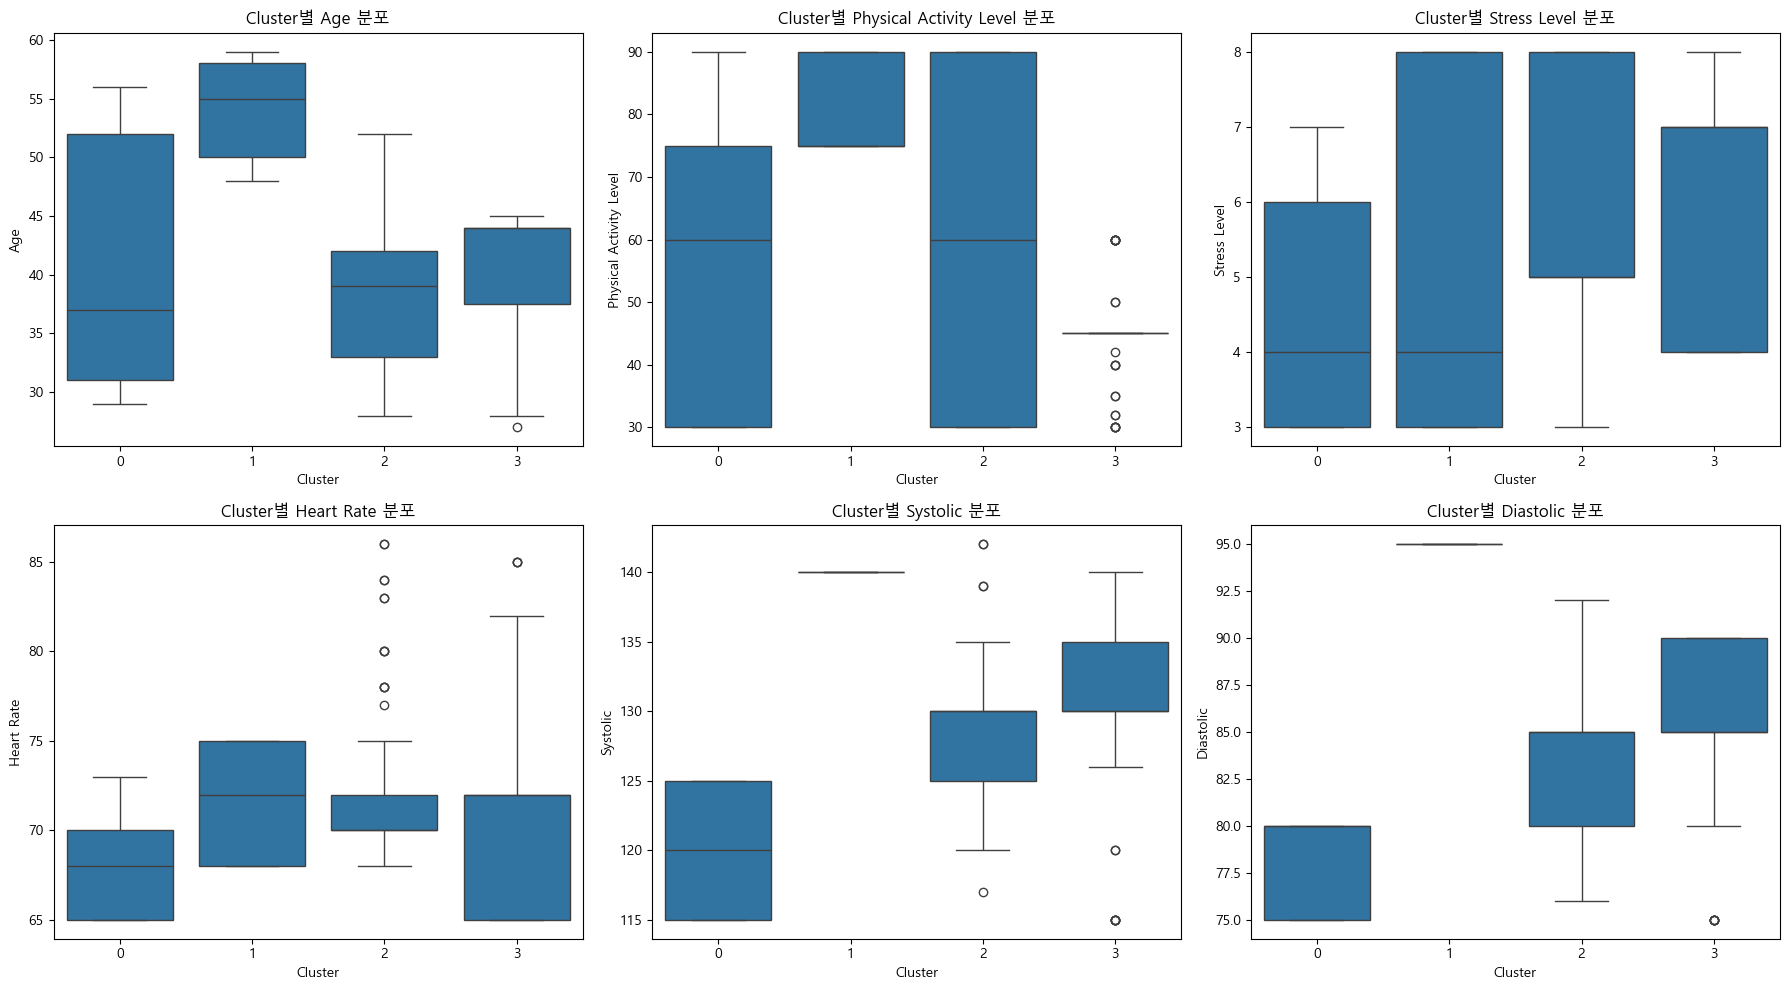

In [39]:

# 시각화할 변수 리스트
features_to_plot = ['Age', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Systolic', 'Diastolic']

# 격자(Grid) 설정: 2행 3열
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    # ★★ 핵심 수정 사항 ★★
    # 원본 df가 아닌, 이상치를 제거하고 Cluster 컬럼이 추가된 'df_clean'을 사용합니다.
    if feature in df.columns:
        ax = axes[i]
        sns.boxplot(x='Cluster', y=feature, data=df, ax=ax) # <--- 이 부분을 df_clean으로 변경!
        ax.set_title(f'Cluster별 {feature} 분포')
        ax.set_xlabel('Cluster')
        ax.set_ylabel(feature)

# 남는 subplot이 있다면 숨김 처리
for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.show()

## Streamlit 대시보드 구현

In [40]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # KMeans를 사용할 경우 import 필요

# df는 이전 단계에서 'Cluster' 컬럼이 추가된 DataFrame이라고 가정합니다.

st.title('수면 건강 맞춤형 군집 분석 대시보드')

st.write("""
사용자들의 건강 데이터를 바탕으로 **4개의 그룹**으로 군집화한 결과입니다.
아래에서 관심 있는 그룹을 선택하여 상세 특징을 확인하고 맞춤형 건강 솔루션을 얻어보세요.
""")

# 군집 선택 박스
# df['Cluster'].unique()는 현재 df에 있는 군집 ID를 자동으로 가져옵니다.
cluster_option = st.selectbox('분석할 군집을 선택하세요:', sorted(df['Cluster'].unique()))

def recommend_sleep(cluster_id):
    if cluster_id == 0:
        return (
            "이 그룹은 비교적 젊은 연령대이며, **수면의 질과 스트레스 관리가 매우 우수한 건강한 군집**입니다. "
            "대부분 정상 체중을 유지하고 심박수와 혈압도 안정적입니다. "
            "현재의 좋은 습관을 계속 유지하고, **주기적인 건강 검진과 자신에게 맞는 꾸준한 신체 활동**으로 건강을 더욱 견고히 다지는 것을 추천합니다."
        )
    elif cluster_id == 1:
        return (
            "이 그룹은 **높은 혈압과 비만도가 특징인 남성 위주의 군집**입니다. "
            "신체 활동 수준은 높은 편이지만, 심혈관 건강에 각별한 주의가 필요합니다. "
            "**나트륨 섭취를 줄이고 칼륨이 풍부한 식품을 섭취하는 식단 개선**이 시급하며, "
            "의료 전문가와 상담하여 혈압과 체중을 관리하는 계획을 세우는 것이 중요합니다. "
            "스트레스 관리 또한 병행되어야 합니다."
        )
    elif cluster_id == 2:
        return (
            "이 그룹은 **젊은 여성의 비율이 높고 스트레스 수준이 높은 것이 특징**입니다. "
            "수면의 질은 평균 수준이지만, 만성적인 스트레스가 건강에 영향을 미칠 수 있습니다. "
            "**명상, 요가, 취미 활동 등 스트레스 해소에 도움이 되는 활동**을 일상에 추가하고, "
            "**규칙적인 수면 시간 확보와 잠자리 환경 개선**을 통해 수면의 질을 높이는 데 집중하는 것을 추천합니다."
        )
    elif cluster_id == 3:
        return (
            "이 그룹은 **수면의 질이 가장 낮고, 신체 활동 수준이 부족하며, 스트레스와 비만도가 높은 복합적인 건강 문제를 가진 군집**입니다. "
            "다양한 직업군에 분포하며, 전반적인 생활 습관 개선이 필요합니다. "
            "**매일 가벼운 산책이나 스트레칭부터 시작하여 점진적으로 활동량을 늘리고**, "
            "**잠들기 전 전자기기 사용 자제, 규칙적인 수면 루틴**을 만드는 것이 중요합니다. "
            "전문가와 상담하여 체계적인 스트레스 및 체중 관리 계획을 세우는 것도 좋은 방법입니다."
        )
    else:
        return "선택된 군집에 대한 분석 정보가 없습니다. 0에서 3까지의 군집을 선택해주세요."

# df에 'Recommendation' 컬럼 추가 (Streamlit 앱 실행 전에 이 부분이 실행되어야 함)
df['Recommendation'] = df['Cluster'].apply(recommend_sleep)

# Streamlit 앱에서 선택된 군집의 특성과 추천 메시지를 표시
# 실제 대시보드에서는 이 부분이 st.write 등으로 연결될 것입니다.
# 예를 들어:
# st.write(f"### 선택된 군집 {cluster_option}의 특징:")
# selected_cluster_data = df[df['Cluster'] == cluster_option].drop(columns=['Cluster', 'Recommendation'], errors='ignore').mean(numeric_only=True)
# st.write(selected_cluster_data)
# st.write(f"### 맞춤형 추천:")
# st.write(df[df['Cluster'] == cluster_option]['Recommendation'].iloc[0])


# plt.show()는 Streamlit 앱에서는 직접적으로 차트를 표시하지 않으므로,
# 실제 Streamlit 코드에서는 st.pyplot(fig)와 같은 방식으로 차트를 통합해야 합니다.
# 이 코드 스니펫은 함수 정의와 컬럼 추가에 중점을 둡니다.

2025-06-20 21:57:40.895 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 21:57:41.420 
  command:

    streamlit run C:\AIDC\workspace\sleep\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-20 21:57:41.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 21:57:41.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 21:57:41.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 21:57:41.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 21:57:41.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 21:57:41.423 Thread 'MainThread

## 군집별 박스 플롯 시각화

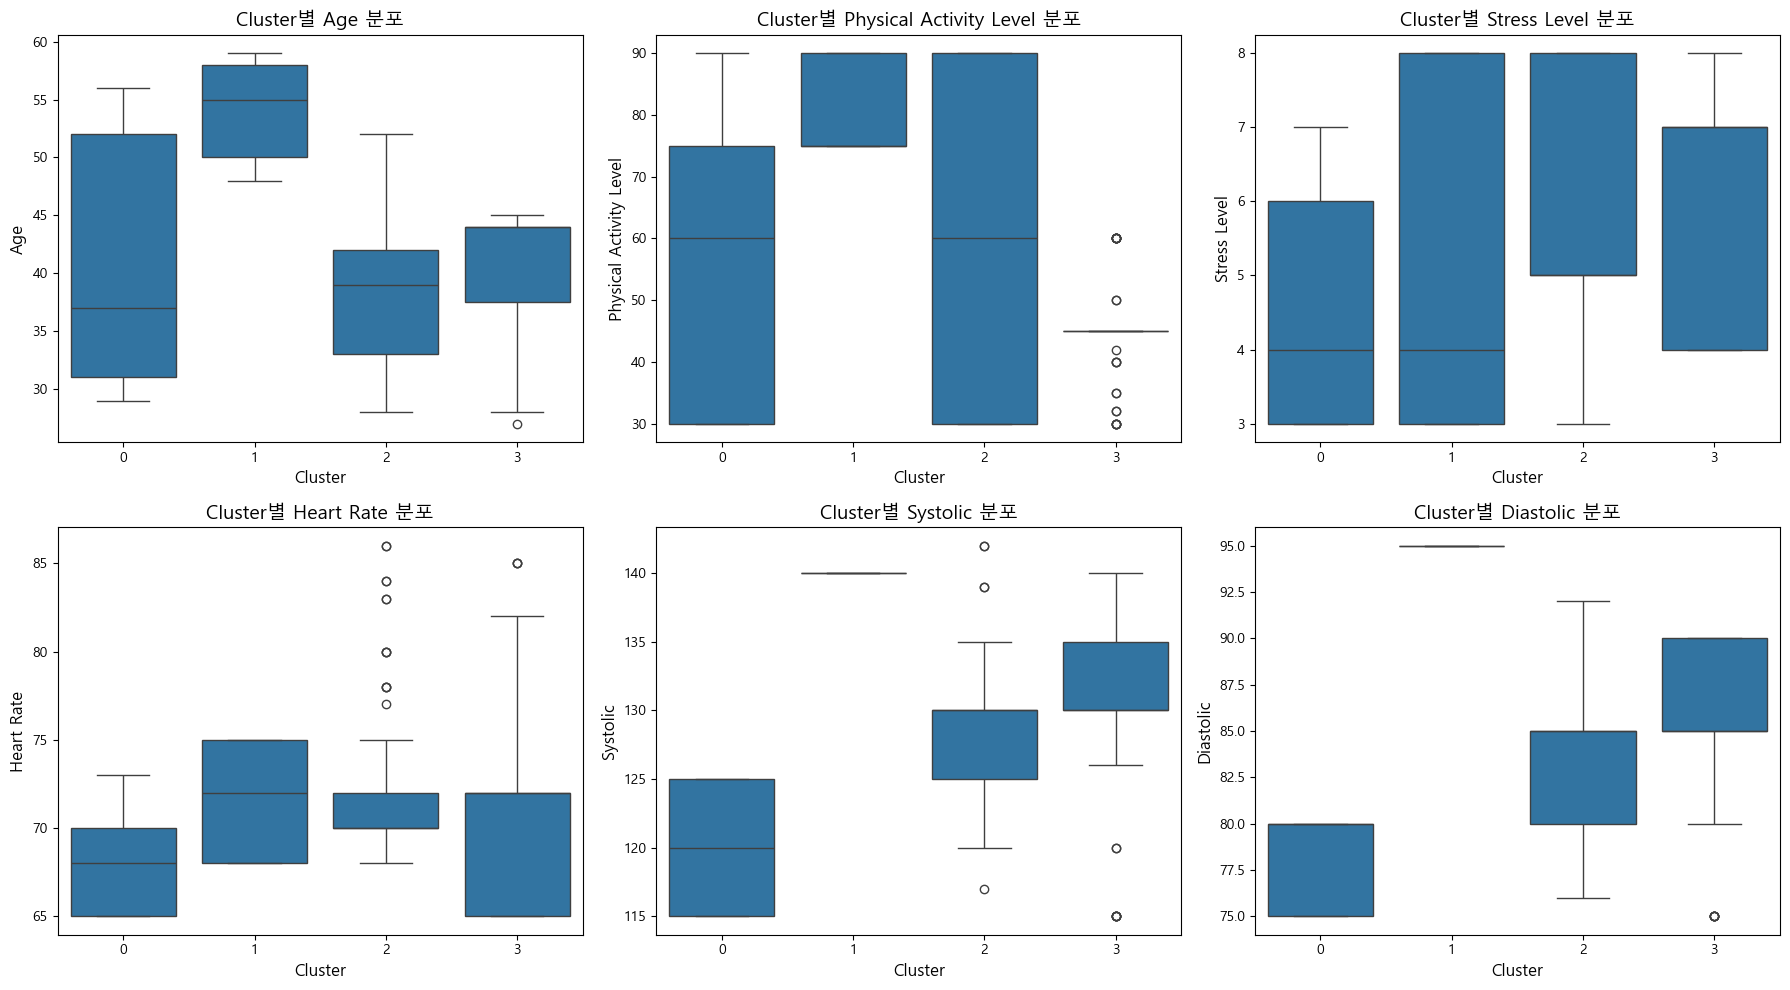

In [41]:
# # 군집별 박스 플롯 시각화
# st.header("군집별 주요 건강 지표 분포 비교")

features_to_plot = ['Age', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Systolic', 'Diastolic']

# 격자(Grid) 설정: 2행 3열
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.boxplot(x='Cluster', y=feature, data=df, ax=ax)
    ax.set_title(f'Cluster별 {feature} 분포', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)

plt.tight_layout()

# 완성된 전체 그림(fig)을 대시보드에 출력
# st.pyplot(fig)
plt.show() # 차트 표시
